### Прогнозирование возраста морского ушка на основе физических измерений.

Возраст морского ушка определяется путем разрезания оболочки через конус, ее окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения этой задачи может потребоваться дополнительная информация, например, о погодных условиях и местоположении (отсюда и наличие продовольствия).


Дано имя атрибута, тип атрибута, единица измерения и
краткое описание.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

Количество колец - это значение для прогнозирования: либо
как непрерывное значение или как проблема классификации. 
Позже мы рассмотрим почему предсказание колец можно также считать задачей классификации.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# from sklearn import курсач
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.neural_network import MLPRegressor
from sklearn.tree import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.externals.six import StringIO

import pydotplus
from IPython.display import Image
import json

import pickle

import tensorflow as tf
import tensorflow.keras as keras

import itertools
from datetime import datetime
import os

from util_funcs import *
import eli5
from eli5.sklearn import PermutationImportance

c:\python38\lib\site-packages\sklearn\externals\six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "
c:\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\python38\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported f

In [2]:
data_path = './data/abalone.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
def show_boxplot(df):
    l = df.loc[:, 'Length':].columns.values
    number_of_columns=9
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],color='green',orient='v')
        plt.tight_layout()

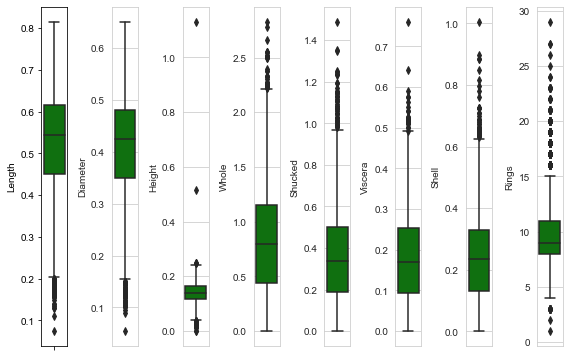

In [6]:
show_boxplot(df)

In [7]:
print("Максимальное количество колец:", df['Rings'].min())
print("Минимальное количество колец:", df['Rings'].max())

Максимальное количество колец: 1
Минимальное количество колец: 29


Теперь стоит рассказать почему предсказание колец может являться задачей классификации. В нашем случае количество колец находится в четком диапазоне (0, 30) и является строго целочисленным. Благодаря чему каждое число количества колец можно считать отдельным классом.

Есть смысл рассмотреть каждый параметр "Пол" отдельно из-за возможной дисперсии в зависимости от этого признака.

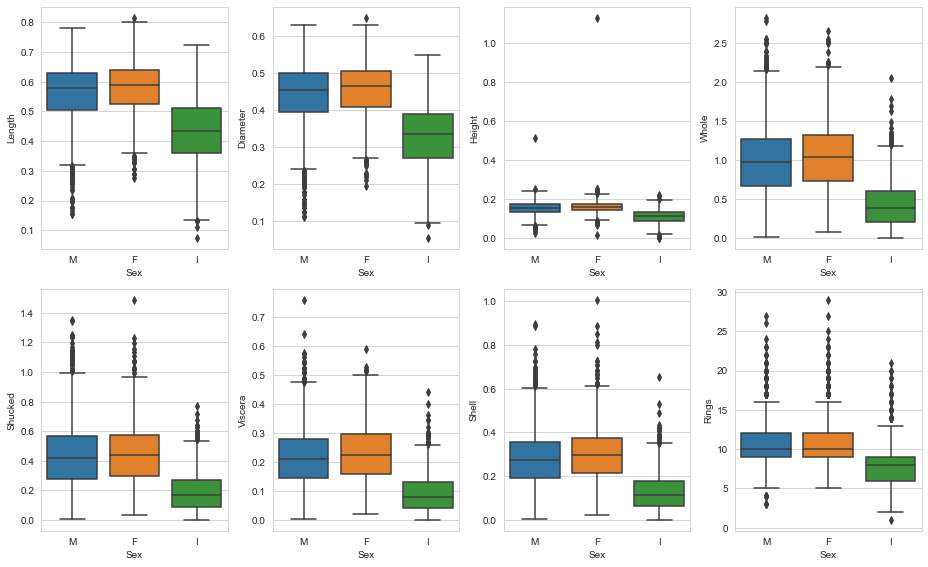

In [8]:
l = df.loc[:, 'Length':].columns
number_of_rows=len(l)
plt.figure(figsize=(13,35))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,4,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x="Sex", y=l[i], data=df, orient='v')
    plt.tight_layout()

Размеры самок обычно наибольшие в популяции, до них идут самцы (тк им нет необходимости создавать потомство), после самцов, напименьшими обычно является подрастающее поколение.

Далее на основе интуитивных соображений.

Преобразуем класс "Пол" в числовое значение (грубый аналог веса). Веса подбирались эксперементально, пытаясь достичь наибольшей кореляции пола к другим параметрам.

In [9]:
df.Sex = df.Sex.transform(lambda x:{"M": 0.8,"F": 1,"I": 0}[x])

In [10]:
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,0.8,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.8,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.8,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


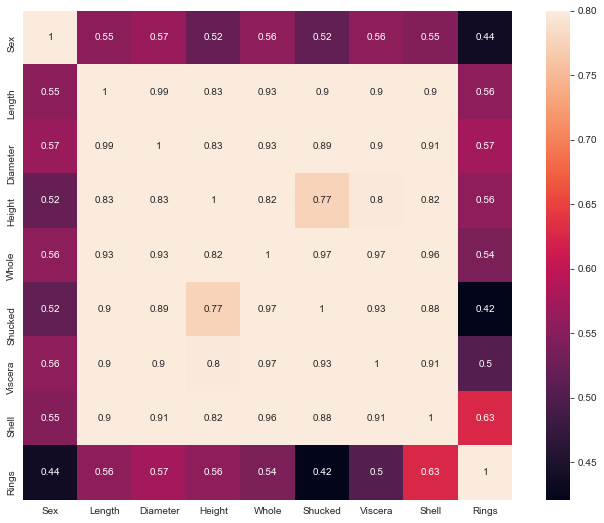

In [11]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [ ]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

Из графиков выше видно, что между почти всеми параметрами прослеживается кореляция. Так же оказалась верна наша догадка насчет пола и их числовых эквивалентов.

Попробуем избавить данные от избыточности.

1. Диаметр, тк линейно зависит от длины
2. Высота, тк линейно зависит от длины

От остальных данных мы избавляться не будет тк это может напрямую повредить точности дальнейших моделей.

In [ ]:
df.drop(['Diameter', 'Height'], axis=1, inplace=True)

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

Подготавливаем заранее данные для обучения. Мы разделяем данные на тренировочные и валидационные. 

И создаем новые фичи:
    1. Полиномиальные
    2. Нормализованные

In [ ]:
X_data, Y_data = df.loc[:,:"Shell"], df["Rings"]
X_data['Whole_L'] = X_data['Whole'] / X_data['Length']
X_train,  X_test,  y_train,  y_test = train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )
splited_data = [X_train, y_train, X_test, y_test]

# данные, дополненные полиномами
poly = PolynomialFeatures(degree = 2)
poly_splited_data = [poly.fit_transform(X_train), y_train, poly.transform(X_test), y_test]
poly_X_data = X_test.copy()
poly_X_data = poly.transform(poly_X_data)

# нормализованные данные
scaler = StandardScaler()
scaler.fit(X_train)
norm_X_train = scaler.transform(X_train)
norm_X_test = scaler.transform(X_test)
norm_splited_data = [norm_X_train, y_train, norm_X_test, y_test]

Для тестирования моделей мы будем округлять результат предсказаний до целого, после считать стандартные для задачи регрессии метрики.

1. средняя ошибка
2. средняя абсолютная ошибка
3. средняя квадратичная ошибка

Пробуем линейную регрессию на оригинальных данных

In [ ]:
#model = load_from_file("models/1_linear_regression.hdf5")
model = LinearRegression()
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Пробуем линейную регрессию на полиномиальных фичах

In [ ]:
#model = load_from_file("models/1_poly_regression.hdf5")
model = LinearRegression()
model.fit(poly_splited_data[0],poly_splited_data[1])
calc_errors(model.predict(poly_splited_data[2]).astype(int), y_test)

Использование полиномиальных фич улучшило результат. Есть смысл попробовать более сложные модели.

Начнем с модели регрессии на основе k-ближайших соседей:

In [ ]:
#model = load_from_file("models/1_n_neighbors_8.hdf5")
model = KNeighborsRegressor(n_neighbors=8)
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

Попробуем случайный лес:

In [ ]:
# model = load_from_file("models/2_voting_lr_rf.hdf5")
m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
m3 = LinearRegression()
model = VotingRegressor(estimators=[('rf', m2), ('lr', m3)])
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

Случайный лес показал результат лучше, чем k-ближайших соседей. Попробуем деревья решений. Для начала создадим функцию для тестирования деревьев с различными параметрами:

In [ ]:
def test_model(trainX, trainY, testX, testY, model, show_model=True, **kwargs):
    if show_model:
        print('Параметры модели:\n', json.dumps(kwargs, indent=2), sep='')
    m = model(**kwargs)
    m.fit(trainX, trainY)  
    print('Точность модели:', m.score(testX, testY))
    print('MAE:', mean_absolute_error(m.predict(testX), testY))
    print()
    return m

def show_graph(m):
    dot_data = StringIO()
    export_graphviz(m, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

Протестируем деревья с различными параметрами:

In [ ]:
test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, criterion='gini')

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, criterion='entropy')

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, splitter='best')

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, splitter='random')

for depth in [1, 2, 4, 8, 10, 15, 20, 50, 100]:
    test_model(X_train, y_train, X_test, y_test,
               DecisionTreeClassifier, max_depth=depth)

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, max_features='auto')

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, max_features='sqrt')

test_model(X_train, y_train, X_test, y_test,
           DecisionTreeClassifier, max_features='log2')

for leaf_nodes in [None, 3, 6, 10, 20, 50, 100]:
    test_model(X_train, y_train, X_test, y_test,
               DecisionTreeClassifier, max_leaf_nodes=leaf_nodes)

В зависимости от методов классификации были получены разные модели. По результатам тестирования можно сделать следующие выводы:
1. У параметра criterion нет явного лидера, на использование entropy чаще дает результат с большей точностью;
2. Параметр splitter также нет явного лидера, но параметр лучше показывает себя в случае с random;
3. В случае параметра max_depth лучше использовать вариант глубины = 4;
4. В случае параметра max_features выгоднее использовать log2;
5. Параметр max_leaf_nodes дал лучший результат со занчением = 20;

С учетом всех наблюдений прстроим модель с параметрами, давшими наилучший результат:

In [ ]:
best_tree = test_model(X_train, y_train, X_test, y_test, 
                       DecisionTreeClassifier, splitter='best',
                       max_depth=10, max_leaf_nodes=25)
calc_errors(best_tree.predict(X_test).astype(int), y_test)
# best_tree = show_graph(best_tree)
# best_tree.write_png('best_tree.png')
# Image(best_tree.create_png())

In [ ]:
perm = PermutationImportance(best_tree, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Точность деревьев крайне мала, поэтому, их использование считаем нецелесообразным.

Попробуем следующую модели, основанные на ансамблях:

In [ ]:
model = load_from_file("models/3_ensemble_40_times_15.hdf5")
print("Модель:\n", model)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
model = load_from_file("models/3_ensemble_30_times_10_15.hdf5")
print("Модель:\n", model)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

На данный момент это наиболее качественная модель, чтобы убедиться в её качестве проверим на кроссвалидации:

In [ ]:
model = BaggingRegressor(base_estimator= MLPRegressor(hidden_layer_sizes=(10,15), solver='lbfgs', random_state=42, max_iter=4500), n_estimators=30, random_state=42)
scores = cross_val_score(model, 
                         X_data, Y_data, cv=4, 
                         scoring=lambda m, x, y: mean_absolute_error(m.predict(x).astype(int), y),
                         n_jobs=-1
                        )
print('Средние абсолютные ошибки полученные на кроссвалидации:', ', '.join(['{0:0.2f}'.format(i) for i in scores])[:-2])

Как мы видели ранее, данные меняются в зависимости от пола. 
Из-за этого есть смысл проанализировать данные отдельно и, при необходимости, посмотреть насколько изменяется качество моделей, 
если строить их для конкретного пола.


Попробуем проанализировать данные по каждому полу отдельно.

In [ ]:
model = BaggingRegressor(base_estimator= MLPRegressor(hidden_layer_sizes=(10,15), solver='lbfgs', random_state=42, max_iter=4500), n_estimators=30, random_state=42)
scores = cross_val_score(model, 
                         X_data, Y_data, cv=4, 
                         scoring=lambda m, x, y: mean_absolute_error(m.predict(x).astype(int), y),
                         n_jobs=-1
                        )
print('Средние абсолютные ошибки полученные на кроссвалидации:', ', '.join(['{0:0.2f}'.format(i) for i in scores])[:-2])

Как мы видели ранее, данные меняются в зависимости от пола. 
Из-за этого есть смысл проанализировать данные отдельно и, при необходимости, посмотреть насколько изменяется качество моделей, 
если строить их для конкретного пола.


Попробуем проанализировать данные по каждому полу отдельно.

In [ ]:
df = pd.read_csv(data_path)
df_M = df[df['Sex']=="M"].copy()
df_F = df[df['Sex']=="F"].copy()
df_I = df[df['Sex']=="I"].copy()

df_M.drop('Sex', axis=1, inplace=True)
df_F.drop('Sex', axis=1, inplace=True)
df_I.drop('Sex', axis=1, inplace=True)

In [ ]:
corrmat = df_M.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [ ]:
df_M.drop(['Diameter', 'Height'], axis=1, inplace=True)

In [ ]:
corrmat = df_F.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

Как видно, параметр Shucked(скорлупа) почти не влияет на возраст и может быть удалён.
Также, в данном случае, мы не удаляем высоту, т.к. она мало корелирует с другими параметрами и скорее всего предоставляет много информации.

In [ ]:
df_F.drop(['Diameter', 'Shucked'], axis=1, inplace=True)

In [ ]:
corrmat = df_I.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [ ]:
df_I.drop(['Length', 'Diameter'], axis=1, inplace=True)

У разных полов различаются корреляции.
Попробуем построить модели для каждого пола по отдельности.

In [ ]:
X_data_M, Y_data_M = df_M.loc[:,:"Shell"], df_M["Rings"]
X_train_M,  X_test_M,  y_train_M,  y_test_M =  train_test_split(X_data_M, Y_data_M,  test_size= 0.20,  random_state= 42 )
splitted_data_M = [X_train_M,  y_train_M, X_test_M,  y_test_M]

X_data_F, Y_data_F = df_F.loc[:,:"Shell"], df_F["Rings"]
X_train_F,  X_test_F,  y_train_F,  y_test_F =  train_test_split(X_data_F, Y_data_F,  test_size= 0.20,  random_state= 42 )
splitted_data_F = [X_train_F,  y_train_F, X_test_F,  y_test_F]

X_data_I, Y_data_I = df_I.loc[:,:"Shell"], df_I["Rings"]
X_train_I,  X_test_I,  y_train_I,  y_test_I =  train_test_split(X_data_I, Y_data_I,  test_size= 0.20,  random_state= 42 )
splitted_data_I = [X_train_I,  y_train_I, X_test_I,  y_test_I]

In [ ]:
test_model_F(*splitted_data_M, LinearRegression, save_model = False)
test_model_F(*splitted_data_F, LinearRegression, save_model = False)
test_model_F(*splitted_data_I, LinearRegression, save_model = False)

Как мы видим:

1. С предсказанием возраста у младенцев неплохо справляется и обычная регрессия
2. Наиболее сложными для предсказания оказались самки

Посмотрим на результаты более детально:

Самцы:

In [ ]:
model = LinearRegression()
model.fit(X_train_M, y_train_M)
calc_errors(model.predict(X_test_M).astype(int), y_test_M)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train_M, y_train_M)
eli5.show_weights(perm, feature_names = X_train_M.columns.tolist())

Самки:

In [ ]:
model = LinearRegression()
model.fit(X_train_F, y_train_F)
calc_errors(model.predict(X_test_F).astype(int), y_test_F)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train_F, y_train_F)
eli5.show_weights(perm, feature_names = X_train_F.columns.tolist())

Младенцы:

In [ ]:
model = LinearRegression()
model.fit(X_train_I, y_train_I)
predicted = model.predict(X_test_I).astype(int)
calc_errors(predicted, y_test_I)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train_I, y_train_I)
eli5.show_weights(perm, feature_names = X_train_I.columns.tolist())

Для представления категориального параметра "Пол" мы уже попробовали грубый аналог веса и раздельние данных. Есть также смысл представить пол с помощью One-Hot Encoding.

In [ ]:
df = pd.read_csv(data_path)
one_hot = pd.get_dummies(df['Sex'])
df = df.drop('Sex',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [ ]:
df.head()

Теперь у нас есть 3 биномиальных предиктора F, I, M

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

Учтем те параметры которые мы удаляли для самок.

In [ ]:
df.drop(['Diameter'], axis=1, inplace=True)

Подготовим данные для тренировки (анлогично тому как мы делали до этого)

In [ ]:
X_data, Y_data = df.drop(['Rings'], axis=1), df["Rings"]


X_train,  X_test,  y_train,  y_test = train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )

Далее протестируем изменение качества предсказания на нескольких моделях:

Линейная регрессия на оригинальных данных:

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Как мы видим модель отдает предпочтение сгенерированным фичам

Случайный лес:

In [ ]:
m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
m3 = LinearRegression()
model = VotingRegressor(estimators=[('rf', m2), ('lr', m3)])
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

По результатам тестирования можно увидеть, что значения оказались хуже, чем на аналогичных моделях при использовнии грубого коэффициента или разделении данных.
Дальнейшие пробы One-Hot Encoding выглядят нецелесообразными.

Далее попробуем генерировать фичи самостоятельно

In [ ]:
df = pd.read_csv(data_path)
one_hot = pd.get_dummies(df['Sex'])
df = df.drop('Sex',axis = 1)
# Join the encoded df
df = df.join(one_hot)

df['Whole_SH'] = df['Whole'] / df['Shucked']
df['Whole_L'] = df['Whole'] / df['Length']
df['Whole_shell'] = df['Whole'] / df['Shell']
df['Whole_Viscera'] = df['Whole'] * df['Viscera']
df['lh'] = df['Length'] * df['Height']
df['lhd'] = df['lh'] * df['Diameter']
df['Shucked_F'] = df['Shucked'] * df['F']
df['Shucked_M'] = df['Shucked'] * df['M']
df['Shell_M'] = df['Shell'] * df['M']
df['Whole_SH_lh'] = df['Whole_SH'] * df['lh']
df.drop(['Diameter', 'M', 'F', 'Whole'], axis=1, inplace=True)

# sns.set()
# sns.pairplot(df, height = 6)
# plt.show()

X_data, Y_data = df.drop(['Rings'], axis=1), df["Rings"]
X_train,  X_test,  y_train,  y_test = train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

Далее протестируем изменение качества предсказания на нескольких моделях:

Линейная регрессия на оригинальных данных:

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [ ]:
scores = cross_val_score(model, 
                         X_data, Y_data, cv=20, 
                         scoring=lambda m, x, y: mean_absolute_error(m.predict(x).astype(int), y),
                         n_jobs=-1
                        )
print('Средние абсолютные ошибки полученные на кроссвалидации:', ', '.join(['{0:0.2f}'.format(i) for i in scores])[:-2])

Случайный лес:

In [ ]:
m2 = RandomForestRegressor(random_state = 42, n_estimators=300)
m3 = LinearRegression()
model = VotingRegressor(estimators=[('rf', m2), ('lr', m3)])
model.fit(X_train, y_train)
calc_errors(model.predict(X_test).astype(int), y_test)

In [ ]:
scores = cross_val_score(model, 
                         X_data, Y_data, cv=20, 
                         scoring=lambda m, x, y: mean_absolute_error(m.predict(x).astype(int), y),
                         n_jobs=-1
                        )
print('Средние абсолютные ошибки полученные на кроссвалидации:', ', '.join(['{0:0.2f}'.format(i) for i in scores])[:-2])

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Результаты при генерации фич выглядят впечатляюще.